# Dataset import from github repo and lybraries import

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import itertools
import random

Set random seeds for reproducibility

In [16]:

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [17]:

import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/Cappsos/DL-image-and-bounding-box-classification/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
  data = pk.load(f)
images = data['imgs']
y = data['labels']
labels = y[:,0]
bboxes = y[:,1:]

# Data visualization

## Make sure that the classes are actually balanced

In [18]:

unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
  print(f"Class: {label}, Count: {count}")


Class: 1, Count: 63
Class: 2, Count: 62
Class: 3, Count: 61


## Before doing anything split train/test data
- I also stratified across image labesl to ensure that the classes balance is mantained
- Also shuffled for robustness

In [19]:

images_train, images_test, labels_train, labels_test, bboxes_train, bboxes_test = train_test_split(images, labels, bboxes, test_size=0.25, random_state=42, stratify=labels, shuffle = True)


In [20]:
# check if they are still balances after the split, they should since i stratified across labels
unique_labels, counts = np.unique(labels_train, return_counts=True)
for label, count in zip(unique_labels, counts):
  print(f"Class: {label}, Count: {count}")

Class: 1, Count: 47
Class: 2, Count: 46
Class: 3, Count: 46


## 2. b) Scaling images in the range [0,1]

In [21]:
# applay min max to images

images_train = (images_train - np.min(images_train)) / np.max(images_train) - np.min(images_train)
images_test = (images_test - np.min(images_test)) /  np.max(images_test) - np.min(images_test)


In [22]:
# subtract 1 to labels to avoid problems in encoding
# labels are in [1,2,3] I trasform them in [0,1,2]

labels_train = [label - 1 for label in labels_train]
labels_test = [label - 1 for label in labels_test ]


In [23]:
bboxes_train.shape

(139, 4)

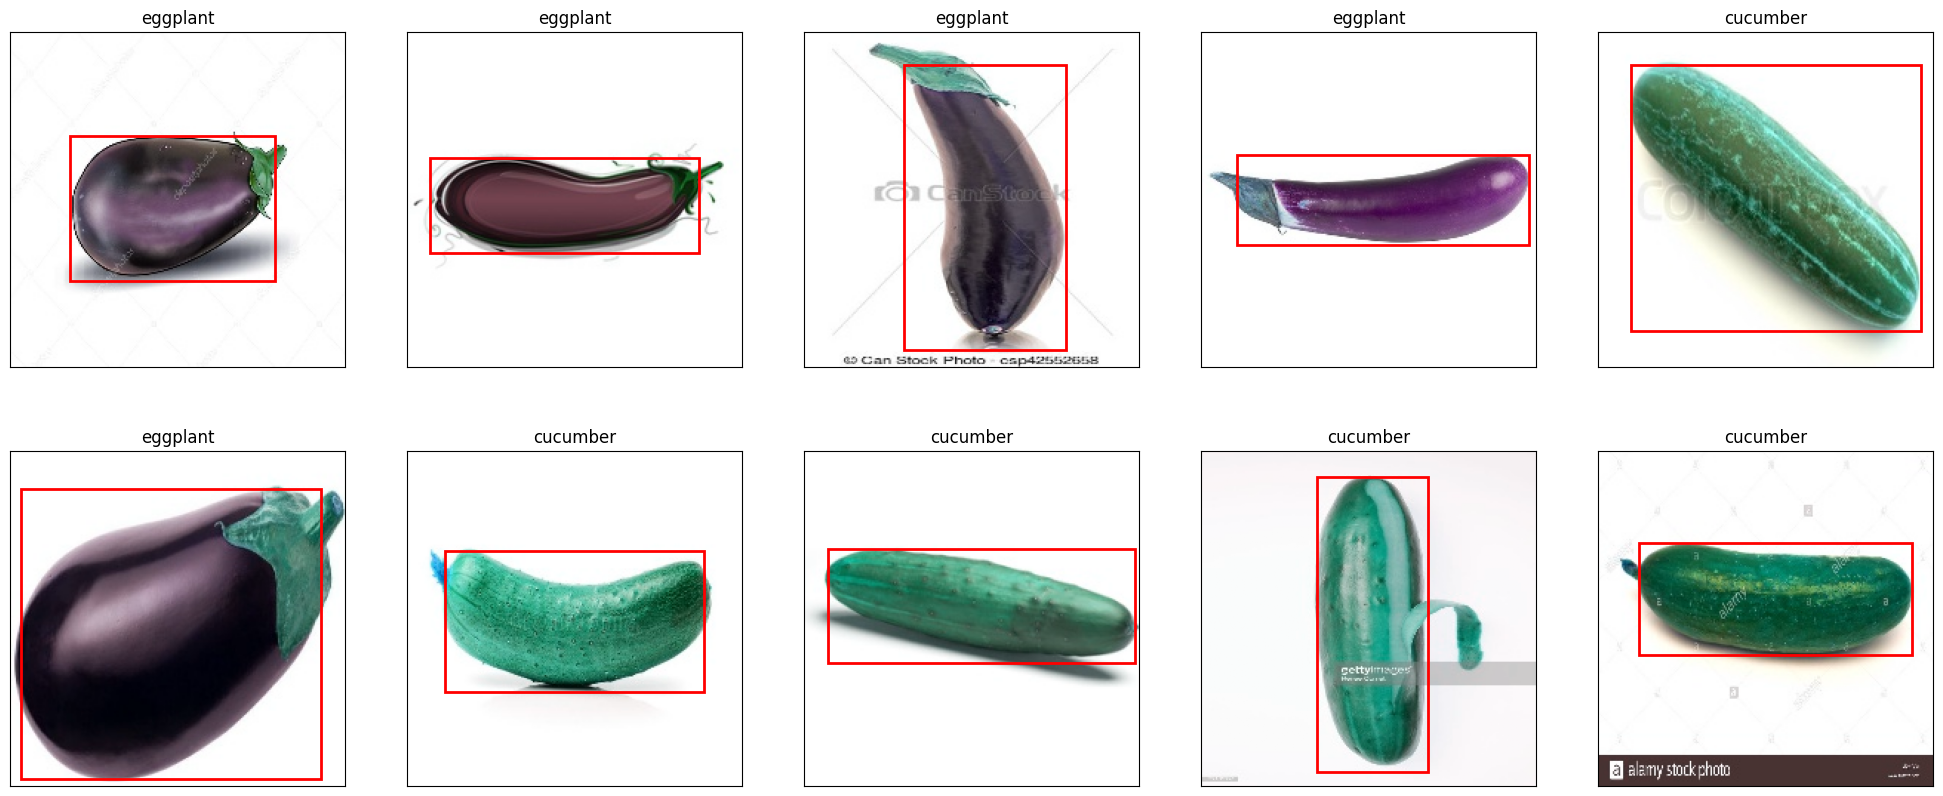

In [24]:
import matplotlib.pyplot as plt

# plot images, labels, and boxes

def plot_images_with_labels(images, labels, bboxes, num_images=10):

    # after ispecting the images, i assigned a named labels to each of the trhree classes just for clarity

    classes = ['cucumber','eggplant','mushroom']

    num_rows = (num_images + 4) // 5  # Calculate number of rows needed

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size based on number of rows

    for i in range(num_images):
        ax = plt.subplot(num_rows, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.title(classes[labels[i]], fontsize=12)

        xmin, ymin, xmax, ymax = bboxes[i]
        width = xmax - xmin
        height = ymax - ymin

        box = plt.Rectangle((xmin, ymin), width, height,
                            fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(box)

    plt.tight_layout()  # Adjust layout to prevent overlap

    plt.subplots_adjust(hspace=0.25)
    plt.show()

plot_images_with_labels(images_train, labels_train, bboxes_train, num_images=10)


After a quick look at the data we are working with, we can start with the data preprocessing steps

# Data preprocessing

- Pixel min/max scale (done before plotting in step before)
- Data augmentation
- Scale bounding boxes to [0,1]
  - x1 = 227*scaled_x1,   y1 = 227 * scaled_y1 ecc


In [25]:
images_train.shape

(139, 227, 227, 3)

# **ERROR CORRECTION: I wrote that i would apply horizontal or vertical trasformations that would not alter the bounding box informations. This is clearly non possible, since the axes on wich we take the symmetry or rotate the image is the central point/ax of the image which does not necessarly coincide with those of the box. During data augmentation i must take care also of the bboxes corodiantes to avoid corrupting relvant informations**


I used the Tensofrlow.image module to augment the data manually (we need to keep the boundix box coherents) https://www.tensorflow.org/api_docs/python/tf/image

- I decided to only do horizontal and up/down transformation. Many others augmentation techniques could be used but by applying those two to each train image we get a good number of training instances. This also help us to train a more robust model

- I also trasform the coordinates of the bounding boxes accordingly

## 2 b) data augmentation

In [26]:
import tensorflow as tf
import numpy as np



def flip_image_and_bbox_horizontally(image, bbox, image_width):

    """Function to horizontally flip an image and adjust bounding box"""

    # flip the image horizontally
    flipped_image = tf.image.flip_left_right(image)

    # get the bbox coordinates
    x_min, y_min, x_max, y_max = tf.split(bbox, 4, axis=-1)

    # shif coordinate x after flip
    new_x_min = image_width - x_max
    new_x_max = image_width - x_min

    # recostuct the bbox vector with new coordinates
    flipped_bbox = tf.concat([new_x_min, y_min, new_x_max, y_max], axis=-1)

    return flipped_image, flipped_bbox


def flip_image_and_bbox_up_down(image, bbox, image_height):

    """Function to vertically flip an image and adjust bounding box"""

    # flip the image vertically
    flipped_image = tf.image.flip_up_down(image)

    # get the bbox coordinates
    x_min, y_min, x_max, y_max = tf.split(bbox, 4, axis=-1)

    # shif coordinate y after flip
    new_y_min = image_height - y_max
    new_y_max = image_height - y_min

    # recostuct the bbox vector with new corrdinates
    flipped_bbox = tf.concat([x_min, new_y_min, x_max, new_y_max], axis=-1)

    return flipped_image, flipped_bbox



# Applying the augmentation to the entire dataset
def augment_dataset(images, labels, bboxes):
    augmented_images = []
    augmented_labels = []
    augmented_bboxes = []

    # augment all training data by applaying horizontal flip
    for i in range(len(images)):
        img, lbl, bbox = images[i], labels[i], bboxes[i]
        aug_img, aug_bbox = flip_image_and_bbox_horizontally(img, bbox, images.shape[1])
        augmented_images.append(aug_img)
        augmented_labels.append(lbl)
        augmented_bboxes.append(aug_bbox)


    # augment all training data by applaying vertical flip
    for i in range(len(images)):
        img, lbl, bbox = images[i], labels[i], bboxes[i]
        aug_img, aug_bbox = flip_image_and_bbox_up_down(img, bbox, images.shape[2])
        augmented_images.append(aug_img)
        augmented_labels.append(lbl)
        augmented_bboxes.append(aug_bbox)

    return tf.stack(augmented_images), tf.stack(augmented_labels), tf.stack(augmented_bboxes)

aug_train_images, aug_train_labels, aug_train_bboxes = augment_dataset(images_train, labels_train, bboxes_train)

Conctatenate the augmented data with the train data

In [27]:
# concatenate aumgented data with original data
images_train = np.concatenate((images_train, aug_train_images), axis=0)
labels_train = np.concatenate((labels_train, aug_train_labels), axis=0)
bboxes_train = np.concatenate((bboxes_train, aug_train_bboxes), axis=0)

Shufle train data since after concatenating with augmentation many istances of the same class are close to eachother

In [28]:
# Create an array of indices and shuffle it
indices = np.arange(images_train.shape[0])
np.random.shuffle(indices)

# Shuffle the data according to the shuffled indices
images_train = images_train[indices]
labels_train = labels_train[indices]
bboxes_train = bboxes_train[indices]

## 2 b) Input shape

In [29]:
# now i have trice as many training images with relatives bounding boxes and labesl
images_train[1].shape

(227, 227, 3)

Scale the bounding boxes coordinates in the [0,1] range

 ## 2 b) scaling bounding boxes

In [30]:
# Scale bounding boxes in 0/1

def scale_bounding_boxes(bboxes, width, height):
    scaled_bboxes = []
    for xmin, ymin, xmax, ymax in bboxes:
        scaled_xmin = xmin / width
        scaled_ymin = ymin / height
        scaled_xmax = xmax / width
        scaled_ymax = ymax / height
        scaled_bboxes.append((scaled_xmin, scaled_ymin, scaled_xmax, scaled_ymax))
    return scaled_bboxes

bboxes_train = np.array(scale_bounding_boxes(bboxes_train, 227, 227))
bboxes_test = np.array(scale_bounding_boxes(bboxes_test, 227, 227))

Perform one-hot encoding of the labels

In [31]:
# one hot of train/test labels


labels_train = to_categorical(labels_train, num_classes = 3)
labels_test = to_categorical(labels_test,num_classes = 3)

In [32]:
labels_train[0]

array([0., 0., 1.], dtype=float32)

## 3 OUTPUT
- Output layers defined as two dense layers one with softmax activatio and 3 units, the other with sigmoid and 4 units

## 4 LOSS
  -   Using the categorical_crossentropy for the classification and the mse for the bbox prediction

## 5 MODEL CONFIGURATION

  - Using glorot initializer for the conv layer and he uniform for the dense
  - Using L2 regularization and ADAM optimizer
  - Using relu activation

# **ERROR CORRECTION: IN THE PAPER I WROTE CONV3D, I ACTUALLY MEANT TO USE CONV2D LAYERS (we didn't even see conv3D architectures in the course...)**

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
# dense is a fully connected layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, Input
from tensorflow.keras.regularizers import l2
from keras import initializers

def cnn_model(filters, kernelsize, n_dense, batch_size, n_classes,input_shape, max_pool_size,regularization_rate,learning_rate):


  filt1, filt2, filt3, filt4, filt5 = filters

  input = Input(shape=input_shape, batch_size= batch_size) # input shape of (batch_size, 227,227,3)

  # first 2 conv2D layers with glorot uniform initialization ()
  hid = Conv2D(filters= filt1, kernel_size = kernelsize, kernel_initializer='glorot_uniform', activation = 'relu', padding='same',kernel_regularizer=l2(regularization_rate))(input)
  hid = Conv2D(filters= filt2,
              kernel_size=kernelsize, activation = 'relu',kernel_initializer='glorot_uniform',
              input_shape = input_shape,
              padding = "same", kernel_regularizer=l2(regularization_rate))(hid)


  # Max pooling
  hid = MaxPooling2D(pool_size=max_pool_size)(hid)

  # second block of conv2D
  hid = Conv2D(filters= filt3,
              kernel_size=kernelsize, activation = 'relu',kernel_initializer='glorot_uniform',
              input_shape = input_shape,
              padding = "same",kernel_regularizer=l2(regularization_rate))(hid)


  hid = Conv2D(filters= filt4,
              kernel_size=kernelsize, activation = 'relu',kernel_initializer='glorot_uniform',
              input_shape = input_shape,
              padding = "same",kernel_regularizer=l2(regularization_rate))(hid)



  # Max pooling
  hid = MaxPooling2D(pool_size=max_pool_size)(hid)

  # Last layer of Conv2D
  hid = Conv2D(filters= filt5,
              kernel_size=kernelsize,kernel_initializer='glorot_uniform',activation = 'relu',
              input_shape = input_shape,
              padding = "same",kernel_regularizer=l2(regularization_rate))(hid)

  # flattening
  hid = Flatten()(hid)


  # dense layers

  for i in range(n_dense):
    hid = Dense(64, activation='relu', kernel_initializer = initializers.HeNormal(), use_bias=True,kernel_regularizer=l2(regularization_rate))(hid)
    #Implementing dropout regularization with p = 0.2
    hid = Dropout(0.2)(hid)

  # output layers
  output_label = Dense(n_classes,activation='softmax',name='label_output')(hid) # multiclass classification
  output_bbox = Dense(4, activation = 'sigmoid',name='bbox_output')(hid) # bbox prediction

  # Model
  model = Model(input, outputs=[output_label, output_bbox])

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                 clipvalue=0.5),
              loss= {'label_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
              metrics={'label_output': 'accuracy', 'bbox_output': 'mse'})


  return model


In [34]:
# initialize model

filters = [16, 32, 64, 64, 32]
max_pool_size = (2, 2)
kernelsize = 3
n_dense = 2
n_classes = len(labels_train[0])
input_shape = (227, 227, 3)
regularization_rate = 0.001 #l2 regularization
batch_size = 16
learning_rate = 0.001
model = cnn_model(filters, kernelsize, n_dense, batch_size, n_classes, input_shape, max_pool_size,regularization_rate,learning_rate)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(16, 227, 227, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (16, 227, 227, 16)           448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (16, 227, 227, 32)           4640      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (16, 113, 113, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

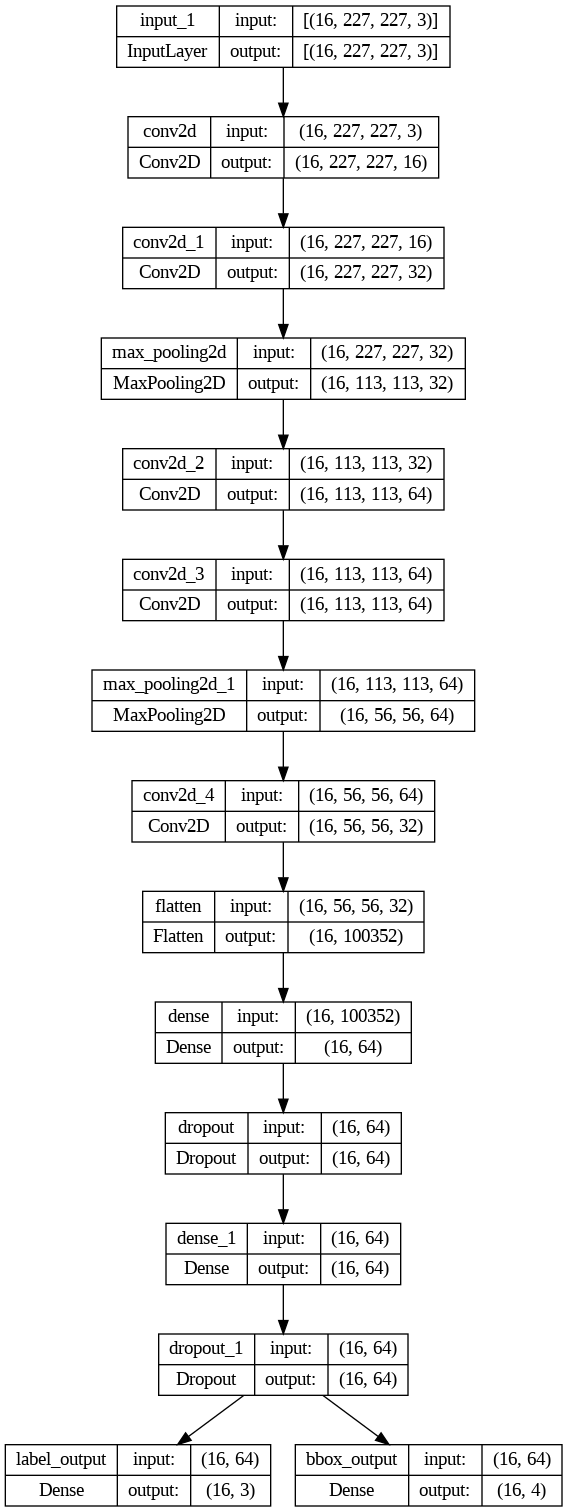

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

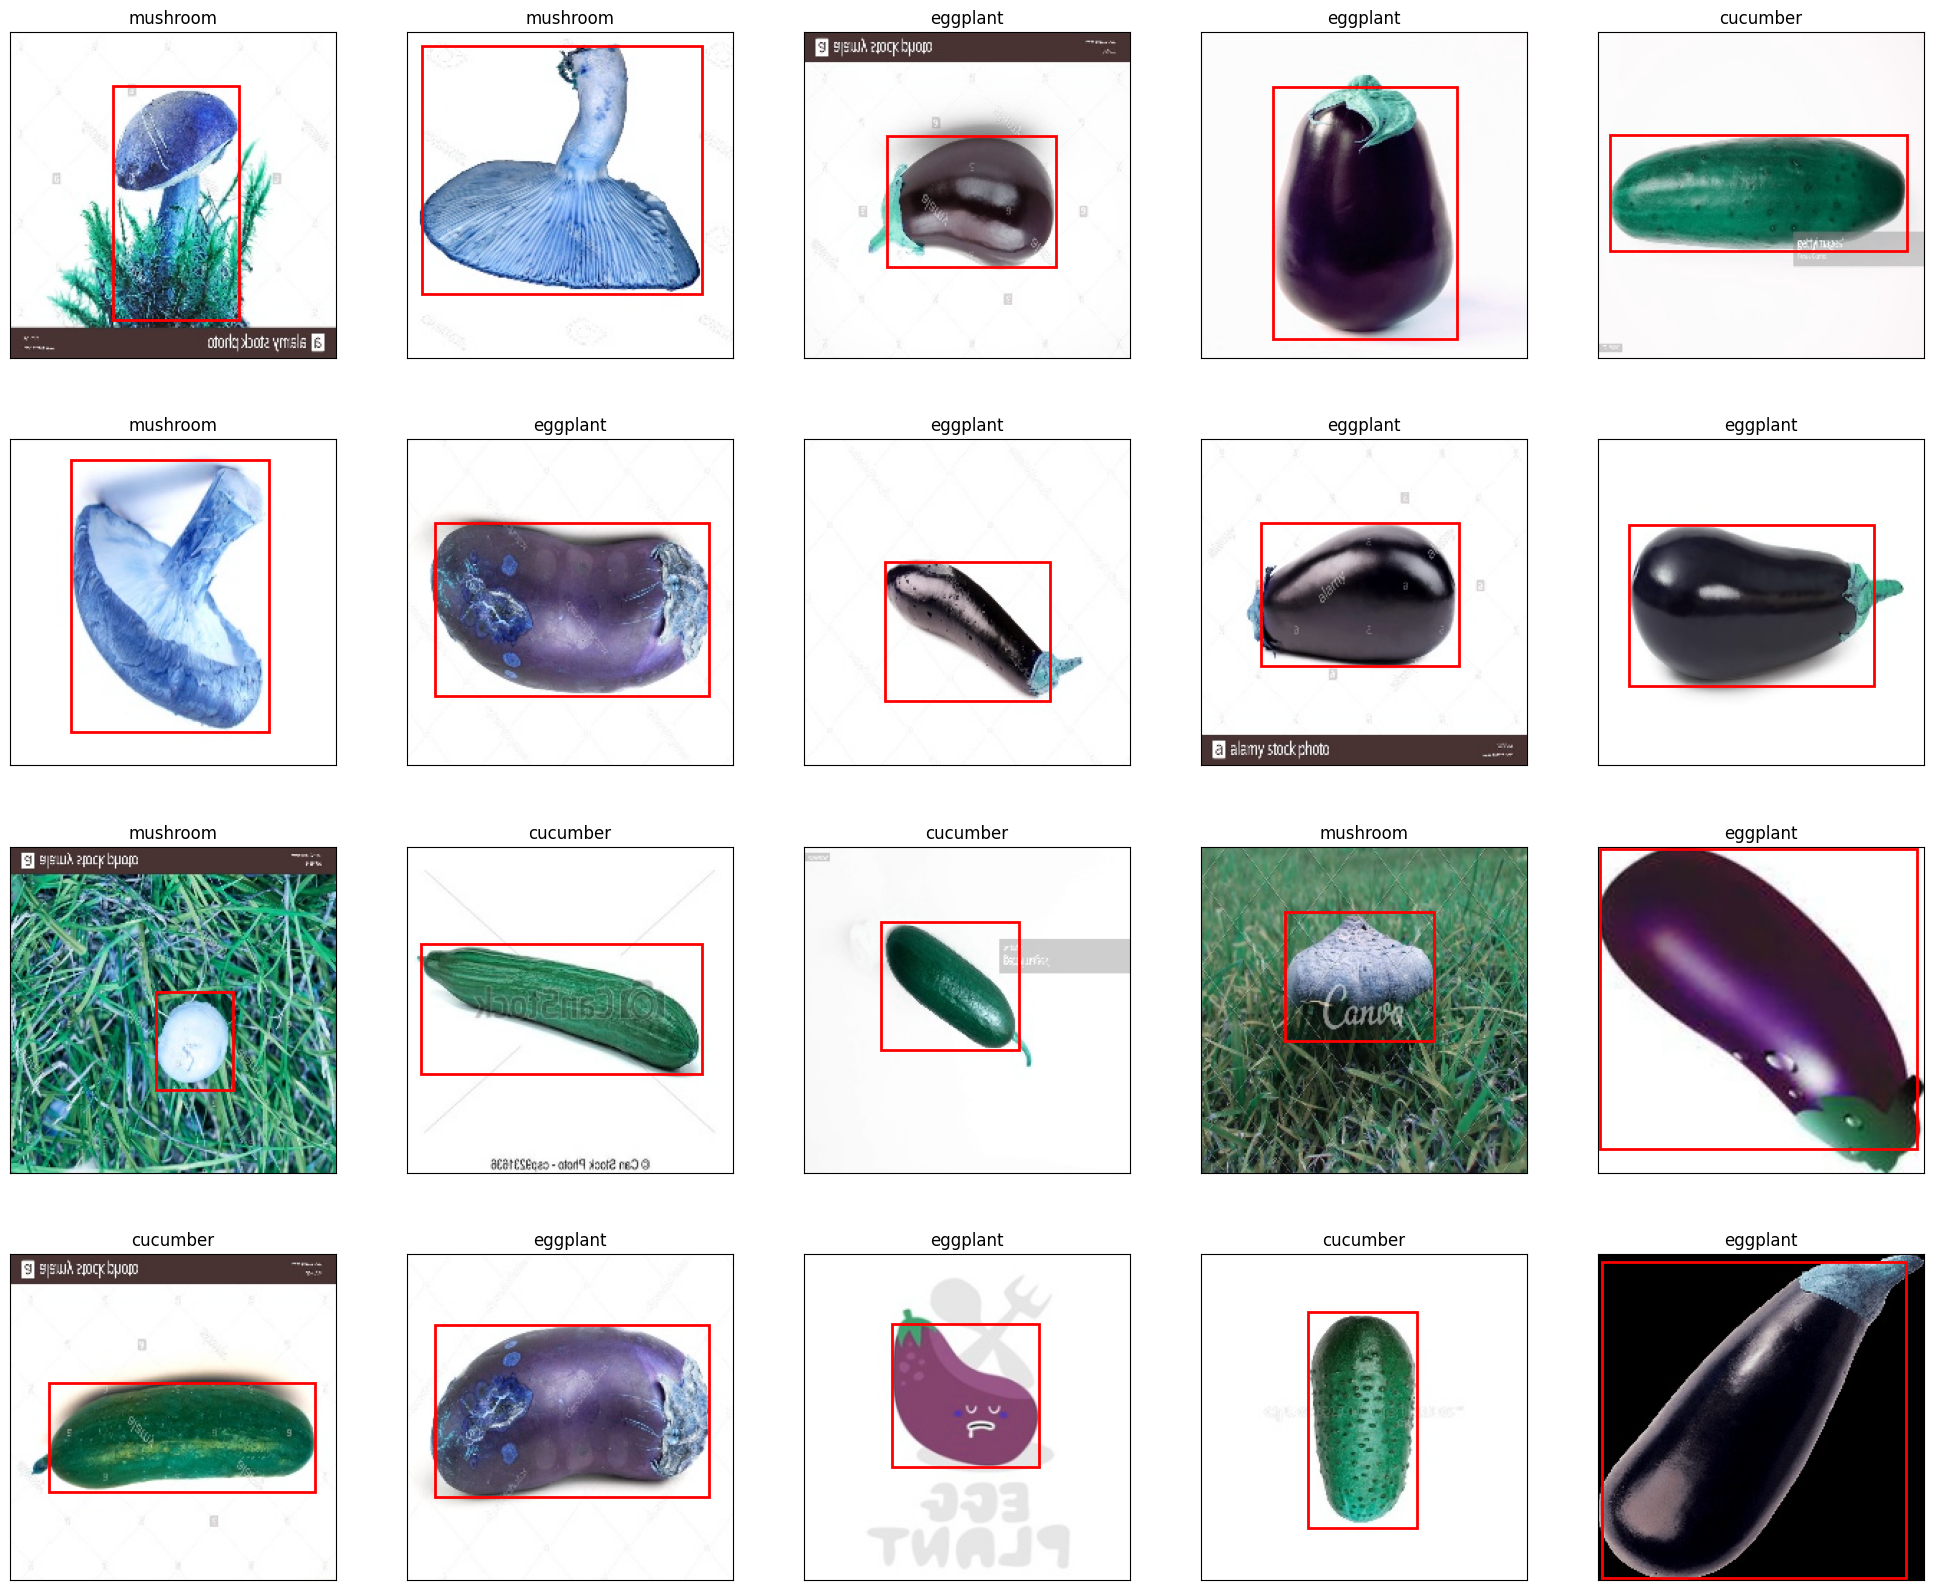

In [36]:
plot_images_with_labels(images_train, [np.argmax(predict) for predict in labels_train.tolist()], (bboxes_train*227).tolist(), num_images=20)

In [37]:
images_train[1].shape

(227, 227, 3)

## Train the initial model

In [38]:

batch_size = 16
epochs = 12

history = model.fit(x=images_train,y={'label_output': labels_train, 'bbox_output': bboxes_train},
          epochs=epochs,
          batch_size = batch_size,
          validation_data=(images_test, {'label_output': labels_test , 'bbox_output': bboxes_test}))

Epoch 1/12
27/27 [==============================] - 18s 134ms/step - loss: 1.4006 - label_output_loss: 0.9615 - bbox_output_loss: 0.0547 - label_output_accuracy: 0.5012 - bbox_output_mse: 0.0547 - val_loss: 0.9781 - val_label_output_loss: 0.5977 - val_bbox_output_loss: 0.0252 - val_label_output_accuracy: 0.7447 - val_bbox_output_mse: 0.0252
Epoch 2/12
27/27 [==============================] - 2s 63ms/step - loss: 0.8865 - label_output_loss: 0.5114 - bbox_output_loss: 0.0412 - label_output_accuracy: 0.7962 - bbox_output_mse: 0.0412 - val_loss: 0.5457 - val_label_output_loss: 0.1996 - val_bbox_output_loss: 0.0269 - val_label_output_accuracy: 0.8936 - val_bbox_output_mse: 0.0269
Epoch 3/12
27/27 [==============================] - 2s 67ms/step - loss: 0.5777 - label_output_loss: 0.2329 - bbox_output_loss: 0.0352 - label_output_accuracy: 0.9305 - bbox_output_mse: 0.0352 - val_loss: 0.4743 - val_label_output_loss: 0.1472 - val_bbox_output_loss: 0.0315 - val_label_output_accuracy: 0.9362 - val

## Evaluate initial model on test set

In [39]:
model.evaluate(x=images_test,y={'label_output': labels_test, 'bbox_output': bboxes_test}, batch_size=16)


3/3 [==============================] - 0s 14ms/step - loss: 0.6332 - label_output_loss: 0.4097 - bbox_output_loss: 0.0341 - label_output_accuracy: 0.9362 - bbox_output_mse: 0.0341


[0.6332117319107056,
 0.40966370701789856,
 0.03409401327371597,
 0.936170220375061,
 0.03409401327371597]

filters, kernelsize, n_dense, batch_size, max_pool_size,regularization_rate,learning_rate

# 5 d) hyperarameters and hypeparameter tuning

- Using itertools i created a search space of possible configurations, then i wrote a custom function to perform k-fold cross validation on a random subset of this search space. This do not guardantee to find the best solution, but to save time i would like to avoid to perform a grid search through all the search space (even if is moderately small), hence the necessity to explore a rundom subset of it.
- This technique could be refined further, to improve perfomances, but since performances are not the focus of this specific project i am satisfied with this solution
- Also, to demostrate that the architecture, with good parameters can actually learn, i used as hyperparameters for the "standard" model trained before, some parameters that during my testing showed promising results

## Parameter to be tuned:
- Number of filters for each Conv2D layer
- Max pool size
- Kernel size
- Number of dense layers
- Initial learning rate
- Batch size
- Regularization rate                            

In [40]:
params = {
    'filters' : [[16, 32, 64, 64, 32], [16,16,32,32,8],  [32, 64, 128, 128, 256], [64, 64, 32, 32, 16]],
    'max_pool' : [(2,2),(3,3),(5,5)],
    'kernelsize' : [3,5],
    'n_dense' : [1,2,3],
    'learning_rate' : [0.001, 0.0001, 0.01],
    'batch_size' : [16, 32],
    'regularization_rate': [0.001, 0.0001, 0.01]
}
# Generate all combinations using itertools.product
param_combinations = list(itertools.product(
    params['filters'],
    params['max_pool'],
    params['kernelsize'],
    params['n_dense'],
    params['learning_rate'],
    params['batch_size'],
    params['regularization_rate']
))

# Print the total number of combinations
print(f"Total combinations: {len(param_combinations)}")

# Print the first few combinations for demonstration
for idx, combination in enumerate(param_combinations[:5]):
    print(f"Combination {idx+1}: {combination}")

# we need to shuffle them
random.shuffle(param_combinations)

print('shuffled:')
for idx, combination in enumerate(param_combinations[:5]):
    print(f"Combination {idx+1}: {combination}")

Total combinations: 1296
Combination 1: ([16, 32, 64, 64, 32], (2, 2), 3, 1, 0.001, 16, 0.001)
Combination 2: ([16, 32, 64, 64, 32], (2, 2), 3, 1, 0.001, 16, 0.0001)
Combination 3: ([16, 32, 64, 64, 32], (2, 2), 3, 1, 0.001, 16, 0.01)
Combination 4: ([16, 32, 64, 64, 32], (2, 2), 3, 1, 0.001, 32, 0.001)
Combination 5: ([16, 32, 64, 64, 32], (2, 2), 3, 1, 0.001, 32, 0.0001)
shuffled:
Combination 1: ([64, 64, 32, 32, 16], (3, 3), 3, 2, 0.0001, 16, 0.0001)
Combination 2: ([16, 32, 64, 64, 32], (2, 2), 3, 1, 0.01, 32, 0.001)
Combination 3: ([16, 16, 32, 32, 8], (2, 2), 3, 3, 0.0001, 32, 0.01)
Combination 4: ([32, 64, 128, 128, 256], (5, 5), 3, 3, 0.001, 16, 0.0001)
Combination 5: ([64, 64, 32, 32, 16], (2, 2), 5, 3, 0.0001, 16, 0.001)


## Search with a limited numbers of epochs to save computational resources and time

In [41]:
from sklearn.model_selection import KFold, cross_val_score

# use sklearn to  create a k-fold object, 2 fold since i have few training param
k_fold = KFold(n_splits=2)





def k_fold_train_test(model, X, y,bboxes_train, k_fold,epochs):
  fold_n = 1

  accuracy_fold = []
  loss_fold = []
  mse_fold = []

  # apply k-fold to split into train and validation
  for train, test in k_fold.split(X, y):
    X_train_fold, X_test_fold = X[train], X[test]
    y_train_fold, y_test_fold = y[train], y[test]
    bboxes_train_fold, bboxes_test_fold = bboxes_train[train], bboxes_train[test]


    print('-'*50)
    print(f'Training for fold {fold_n}:')

    # train the model on the given parameters
    history = model.fit(x=X_train_fold,y={'label_output': y_train_fold, 'bbox_output': bboxes_train_fold},
          epochs=epochs,
          batch_size = batch_size)

    # evaluate on the validation data
    score = model.evaluate(x=X_test_fold,y={'label_output': y_test_fold, 'bbox_output': bboxes_test_fold}, batch_size=batch_size)

    print(f"\n Scores for fold {fold_n}: {model.metrics_names[0]} of {round(score[0],3)}; {model.metrics_names[3]} of {round(score[3],3)};{model.metrics_names[4]} of {round(score[4],3)}")

    accuracy_fold.append(score[3])
    loss_fold.append(score[0])
    mse_fold.append(score[4])

    fold_n += 1

  # select as score the classification score (i must chose one of the 2 to be able to choose a "best" model)
  # i used accuracy since during testing i noticed that good classifiers also perform good on bbopx task
  score = np.mean(accuracy_fold)
  print(f"Average accuracy: {round(score,3)}")

  return score





# applay cross val to choose best model
def cross_val_score(X, y,bboxes_train, parameters, k_fold, epochs, max_iter = 5):

    best_model = None
    best_score = float('-inf')
    best_param = None

    iter = 1
    total_param = len(parameters)



    # pick a random subset of max_iter size from the search space
    random_indices = random.sample(range(total_param), max_iter)
    potential_config = [parameters[i] for i in random_indices]

    print(f"Total iterations: {len(potential_config)}")


# find the best configuration in the subspace
    for params in potential_config:

      print(f"Iter {iter}/{max_iter}")
      filters, max_pool, kernelsize, n_dense, learning_rate, batch_size, regularization_rate = params
      print(f"filters: {filters}, max_pool: {max_pool}, kernelsize: {kernelsize}, n_dense: {n_dense}, learning_rate: {learning_rate}, regularization_rate: {regularization_rate}, batch_size: {batch_size}")

      input_shape = (227, 227, 3)
      n_classes = len(y[0])

      cv_model = cnn_model(filters, kernelsize, n_dense, batch_size, n_classes, input_shape, max_pool,regularization_rate,learning_rate)

      score = k_fold_train_test(cv_model,X, y, bboxes_train,k_fold,epochs)
      if score > best_score:
        best_model = cv_model
        best_score = score
        best_param = params

      iter += 1
      max


    return best_model, best_score, best_param



best_model, best_score, best_param = cross_val_score(images_train, labels_train, bboxes_train, param_combinations, k_fold, epochs = 12 )

Total iterations: 5
Iter 1/5
filters: [16, 16, 32, 32, 8], max_pool: (2, 2), kernelsize: 3, n_dense: 1, learning_rate: 0.01, regularization_rate: 0.001, batch_size: 32
--------------------------------------------------
Training for fold 1:
Epoch 1/12
13/13 [==============================] - 5s 27ms/step - loss: 1.6773 - label_output_loss: 1.1630 - bbox_output_loss: 0.0665 - label_output_accuracy: 0.3462 - bbox_output_mse: 0.0665
Epoch 2/12
13/13 [==============================] - 0s 27ms/step - loss: 1.6708 - label_output_loss: 1.1225 - bbox_output_loss: 0.0310 - label_output_accuracy: 0.3365 - bbox_output_mse: 0.0310
Epoch 3/12
13/13 [==============================] - 0s 28ms/step - loss: 1.4782 - label_output_loss: 1.1188 - bbox_output_loss: 0.0406 - label_output_accuracy: 0.3654 - bbox_output_mse: 0.0406
Epoch 4/12
13/13 [==============================] - 0s 27ms/step - loss: 1.3866 - label_output_loss: 1.1578 - bbox_output_loss: 0.0226 - label_output_accuracy: 0.3846 - bbox_output_

### Best model parameters

In [42]:
best_param

([16, 16, 32, 32, 8], (5, 5), 3, 1, 0.001, 32, 0.0001)

In [43]:
# see performance of best model on test set
best_model.evaluate(x=images_test,y={'label_output': labels_test, 'bbox_output': bboxes_test}, batch_size=16)

3/3 [==============================] - 1s 222ms/step - loss: 0.1212 - label_output_loss: 0.0800 - bbox_output_loss: 0.0237 - label_output_accuracy: 0.9787 - bbox_output_mse: 0.0237


[0.12122737616300583,
 0.07996367663145065,
 0.023672260344028473,
 0.978723406791687,
 0.023672260344028473]

In [52]:
# retrain the best model on all the train set and on more epochs

filters, max_pool, kernelsize, n_dense, learning_rate, batch_size, regularization_rate = best_param
input_shape = (227, 227, 3)
n_classes = len(labels_train[0])

best_model = cnn_model(filters, kernelsize, n_dense, batch_size, n_classes, input_shape, max_pool_size,regularization_rate,learning_rate)

best_model.fit(x=images_train,y={'label_output': labels_train, 'bbox_output': bboxes_train},
          epochs=30,
          batch_size = batch_size)

Epoch 1/30
14/14 [==============================] - 3s 61ms/step - loss: 1.1753 - label_output_loss: 1.0967 - bbox_output_loss: 0.0593 - label_output_accuracy: 0.3597 - bbox_output_mse: 0.0593
Epoch 2/30
14/14 [==============================] - 1s 55ms/step - loss: 0.6312 - label_output_loss: 0.5843 - bbox_output_loss: 0.0295 - label_output_accuracy: 0.7314 - bbox_output_mse: 0.0295
Epoch 3/30
14/14 [==============================] - 1s 59ms/step - loss: 0.4762 - label_output_loss: 0.4230 - bbox_output_loss: 0.0357 - label_output_accuracy: 0.8177 - bbox_output_mse: 0.0357
Epoch 4/30
14/14 [==============================] - 1s 59ms/step - loss: 0.2182 - label_output_loss: 0.1656 - bbox_output_loss: 0.0349 - label_output_accuracy: 0.9616 - bbox_output_mse: 0.0349
Epoch 5/30
14/14 [==============================] - 1s 60ms/step - loss: 0.1277 - label_output_loss: 0.0706 - bbox_output_loss: 0.0391 - label_output_accuracy: 0.9736 - bbox_output_mse: 0.0391
Epoch 6/30
14/14 [=================

# 6) Performance assesment

In [53]:
# asses performances of the final model
best_model.evaluate(x=images_test,y={'label_output': labels_test, 'bbox_output': bboxes_test}, batch_size=16)

3/3 [==============================] - 0s 21ms/step - loss: 0.2795 - label_output_loss: 0.2485 - bbox_output_loss: 0.0158 - label_output_accuracy: 0.9574 - bbox_output_mse: 0.0158


[0.2794749140739441,
 0.2484612613916397,
 0.015776338055729866,
 0.957446813583374,
 0.015776338055729866]

In [46]:

def predict(images, model):

  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions[0], axis=1)
  predicted_bboxes = predictions[1]

  return predicted_labels, predicted_bboxes





### INITIAL MODEL

In [47]:
predicted_labels_initial, predicted_bboxes_initial = predict(images_test, model)

2/2 [==============================] - 1s 10ms/step


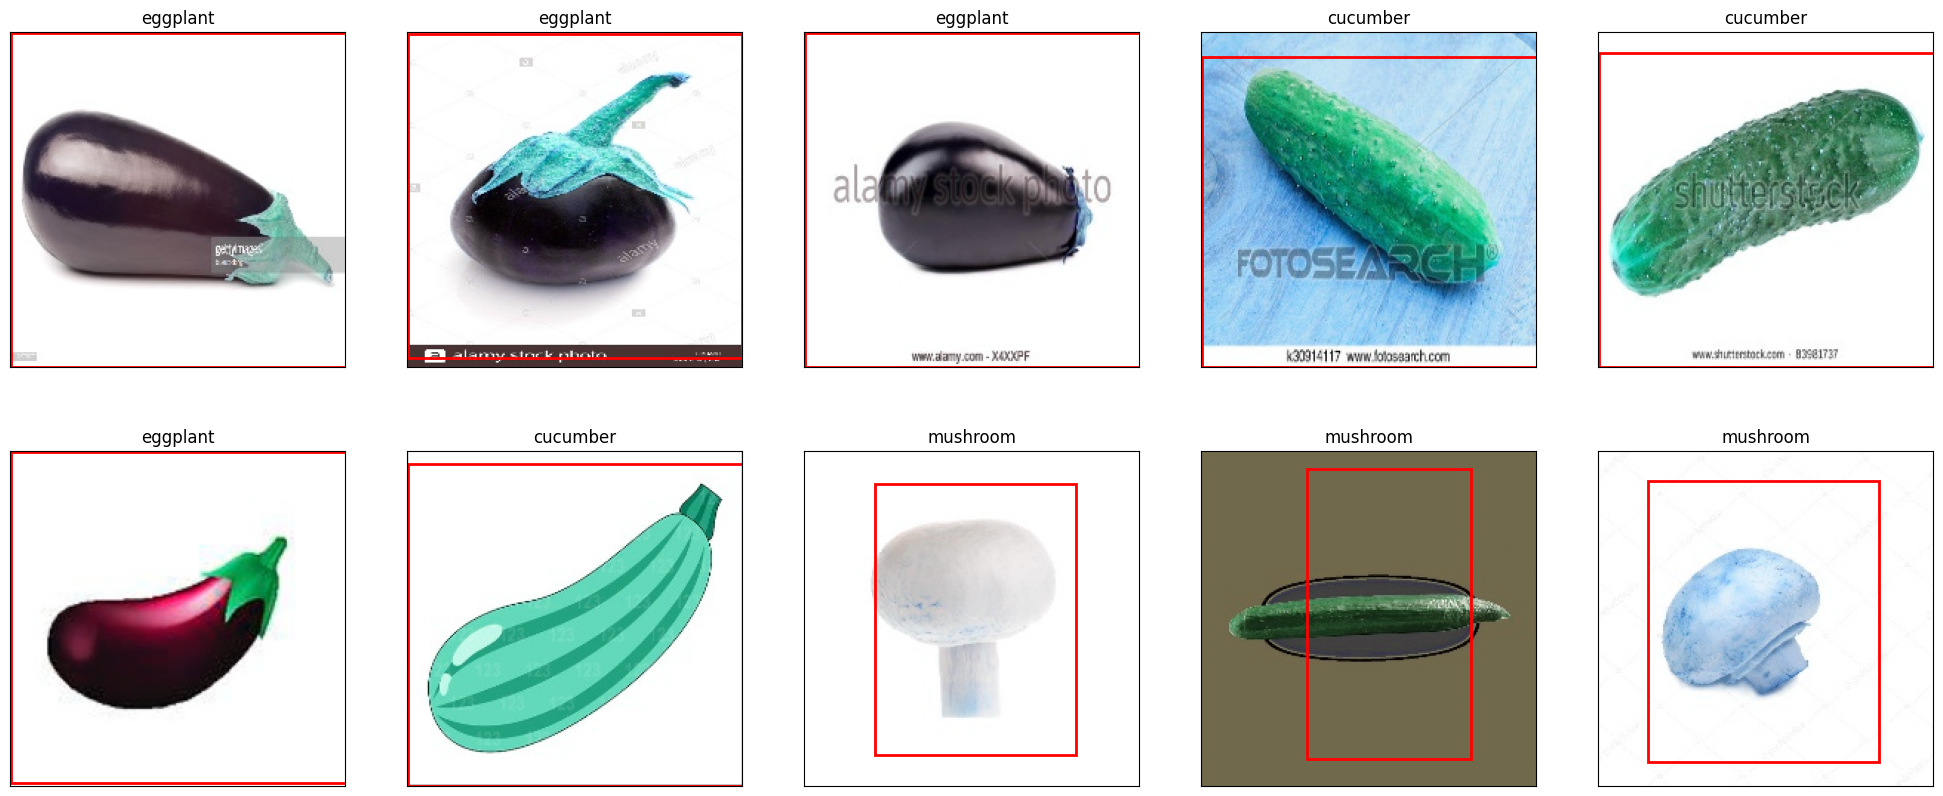

In [48]:
plot_images_with_labels(images_test, predicted_labels_initial.tolist(), (predicted_bboxes_initial*227).tolist(), num_images=10)

### BEST MODEL FOUND

In [56]:
predicted_labels, predicted_bboxes = predict(images_test, best_model)

2/2 [==============================] - 0s 19ms/step


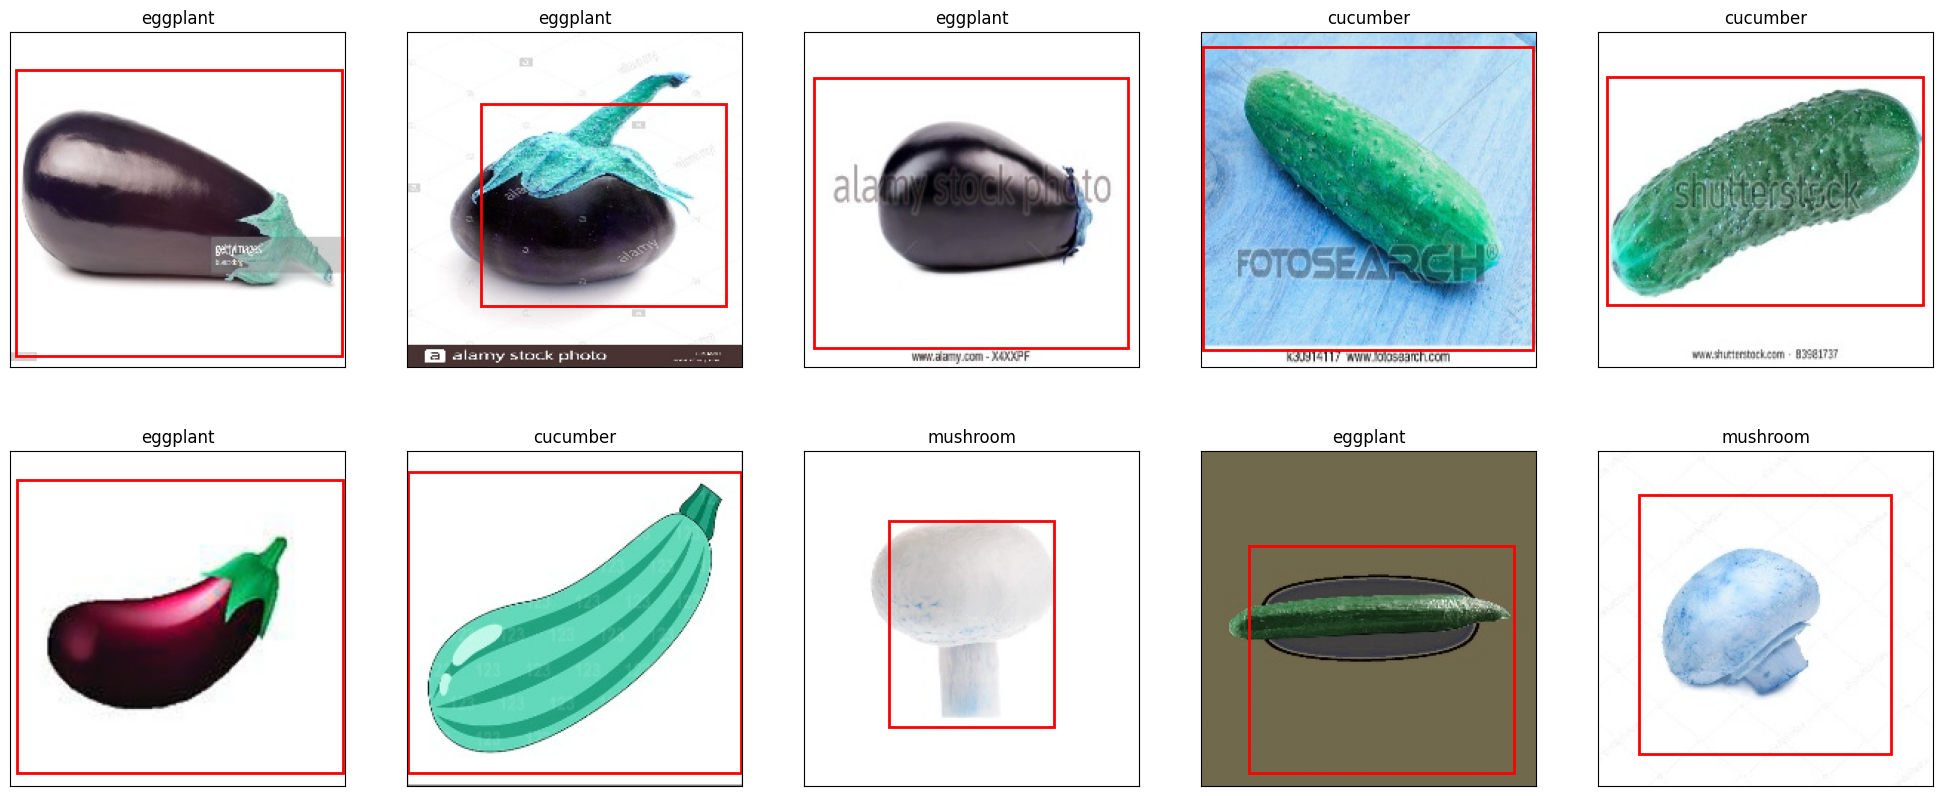

In [57]:
plot_images_with_labels(images_test, predicted_labels.tolist(), (predicted_bboxes*227).tolist(), num_images=10)

### TEST REFERENCE

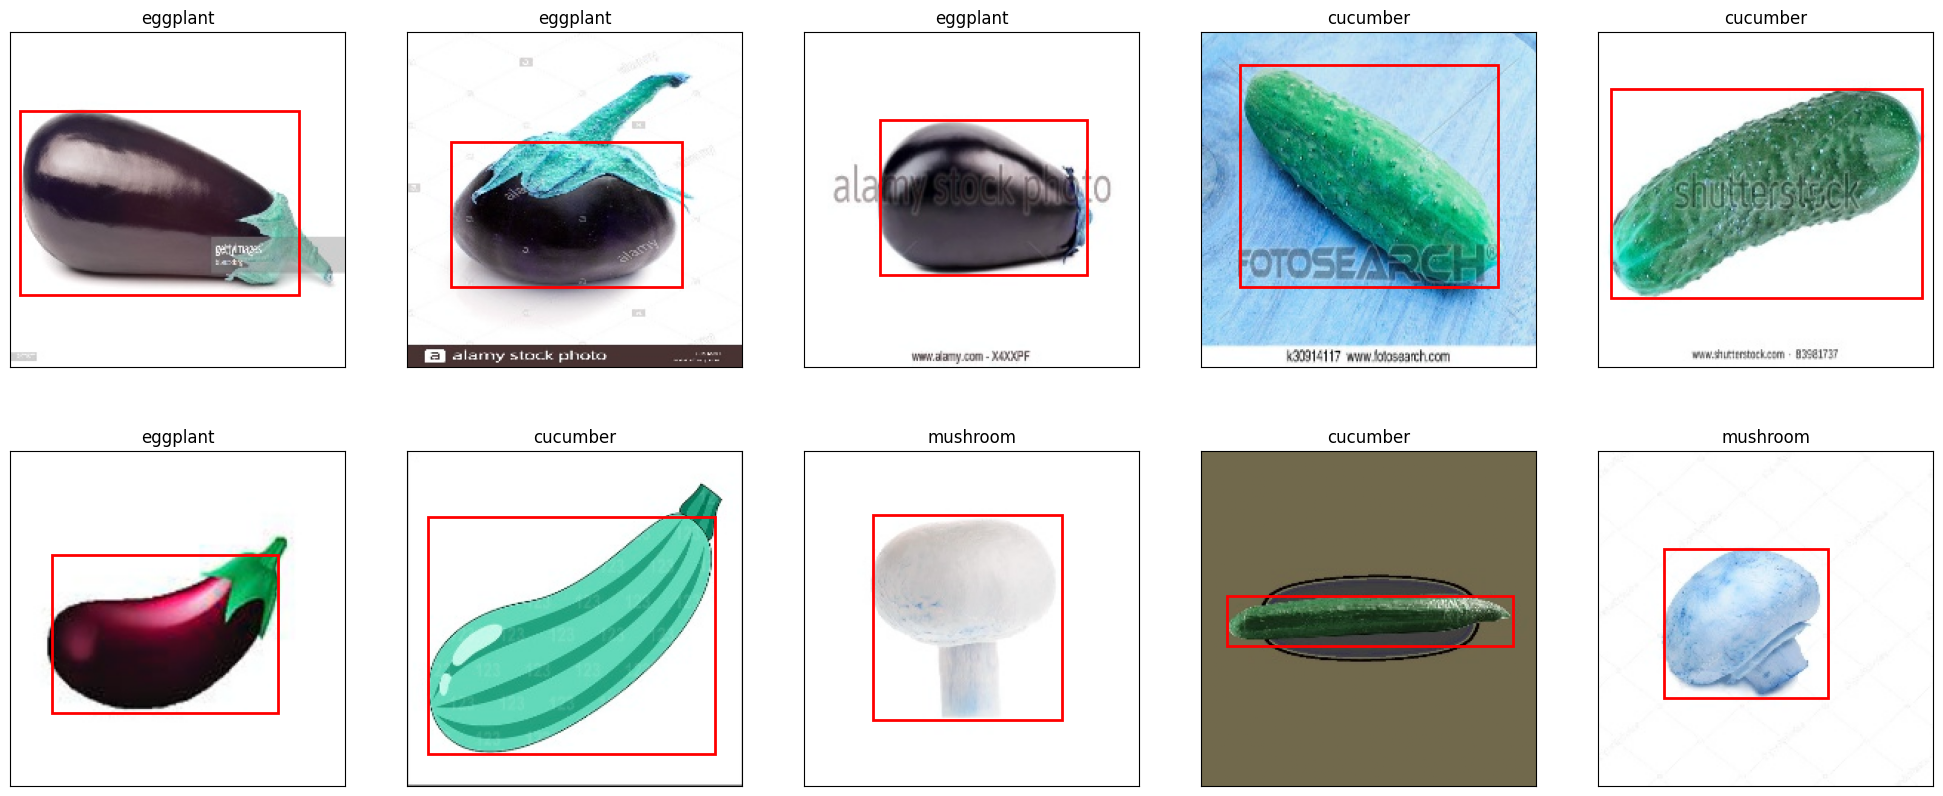

In [51]:
plot_images_with_labels(images_test, [np.argmax(predict) for predict in labels_test.tolist()], (bboxes_test*227).tolist(), num_images=10)